# autoencoder for time to time. i.e. the input to encoder is 1D and the output from decoder is 1D

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [3]:
training_data = load_training_data(root_dir="training_data")

In [4]:
validation_data = load_training_data(root_dir="validation_data")

In [5]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [6]:
def setup_modelling(data_name, training_data, validation_data, training_approxs=None, validation_approxs=None, sample_weights_dict=None):
    assert data_name in ['amplitude', 'phase'], 'unknown data_name'
        
    y = training_data[data_name]
    x = training_data['mass_ratios']

    yval = validation_data[data_name]
    xval = validation_data['mass_ratios']

    times = training_data['times']
    
    if training_approxs == None:
        training_approxs = training_data['unique_approximants']
    if validation_approxs == None:
        validation_approxs = validation_data['unique_approximants']
    
    print("training data")
    for i, approx in enumerate(training_approxs):
        if i == 0:
            mask = training_data['mask'][approx]
        else:
            mask = np.concatenate((mask, training_data['mask'][approx]))
        print(f"{approx} has {len(training_data['mask'][approx])} samples")
    print("\t **if the number of samples for each class are not equal then maybe you should use sample weighting**")
    x = x[mask]
    y = y[mask]
    approximants = training_data['approximants'][mask]
    
    output_dict = dict(x=x, y=y, times=times, approximants=approximants)
    
    # https://www.tensorflow.org/guide/keras/train_and_evaluate#sample_weights
    if sample_weights_dict is not None:
        assert set(training_approxs).isdisjoint(set(list(sample_weights_dict.keys()))) == False, "sample_weights_dict contains keys that are not in the training set"
        sample_weight = np.ones(shape=(len(y),))
        for k, v in sample_weights_dict.items():
            mask = k==approximants
            sample_weight[mask] = v
        output_dict.update({'sample_weight':sample_weight})
        
        
    print("validation data")
    for i, approx in enumerate(validation_approxs):
        if i == 0:
            mask = validation_data['mask'][approx]
        else:
            mask = np.concatenate((mask, validation_data['mask'][approx]))
        print(f"{approx} has {len(validation_data['mask'][approx])} samples")
    xval = xval[mask]
    yval = yval[mask]
    approximants_val = validation_data['approximants'][mask]
    
    output_dict.update({'xval':xval, 'yval':yval, 'approximants_val':approximants_val})
        
    return output_dict

In [7]:
data_name = 'amplitude'
# data_name = 'phase'
# sample_weights_dict = {'NR':20.}
# training_approxs=["IMRPhenomD", "SEOBNRv4_opt", "NR"]
# validation_approxs=["IMRPhenomD", "SEOBNRv4_opt"]
sample_weights_dict = None
# training_approxs=["IMRPhenomD", "SEOBNRv4_opt"]
# validation_approxs=["IMRPhenomD", "SEOBNRv4_opt"]
training_approxs=["IMRPhenomD"]
validation_approxs=["IMRPhenomD"]
# training_approxs=["SEOBNRv4_opt"]
# validation_approxs=["SEOBNRv4_opt"]
modelling_params = setup_modelling(data_name, training_data, validation_data, training_approxs=training_approxs, validation_approxs=validation_approxs, sample_weights_dict=sample_weights_dict)

training data
IMRPhenomD has 100 samples
	 **if the number of samples for each class are not equal then maybe you should use sample weighting**
validation data
IMRPhenomD has 180 samples


In [26]:
modelling_params.keys()

dict_keys(['x', 'y', 'times', 'approximants', 'xval', 'yval', 'approximants_val'])

In [8]:
modelling_params['y'].shape

(100, 1150)

In [10]:
modelling_params['times'].shape

(1150,)

In [11]:
modelling_params['x'].shape

(100,)

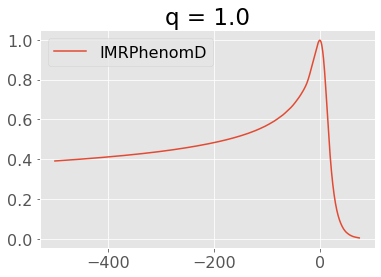

In [9]:
plt.figure()
plt.plot(modelling_params['times'], modelling_params['y'][0], label=modelling_params['approximants'][0])
plt.title(f"q = {modelling_params['x'][0]}")
plt.legend()

# turn input data into hyper-surface

In [8]:
modelling_params['y'].shape

(100, 1150)

In [10]:
modelling_params['times'].shape

(1150,)

In [11]:
modelling_params['x'].shape

(100,)

In [15]:
def get_ann_input(t, x):
    xx, yy = np.meshgrid(t, x)
    xx = xx.ravel()
    yy = yy.ravel()
    return np.column_stack((xx, yy))

In [16]:
X_train = get_ann_input(modelling_params['times'], modelling_params['x'])

In [17]:
X_train.shape

(115000, 2)

In [36]:
y_train = modelling_params['y'].ravel()
y_train = y_train.reshape(-1, 1)

In [27]:
X_val = get_ann_input(modelling_params['times'], modelling_params['xval'])

In [28]:
X_val.shape

(207000, 2)

In [35]:
y_val = modelling_params['yval'].ravel()
y_val = y_val.reshape(-1, 1)

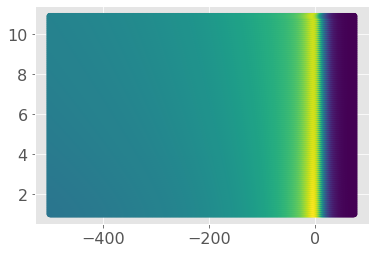

In [37]:
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

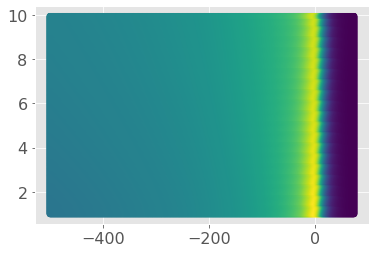

In [38]:
plt.figure()
plt.scatter(X_val[:,0], X_val[:,1], c=y_val)

In [21]:
plt.figure()
plt.plot(modelling_params['times'], modelling_params['y'][0])
plt.plot(modelling_params['times'], modelling_params['y'][-1])

### build a standard autoencoder

In [22]:
def build_encoder(input_shape, latent_dim, units, acts):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(timeseries_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_model = keras.Model(timeseries_input, latent_output)
#     print("=" * 20)
#     print("encoder summary")
#     print("=" * 20)
#     encoder_model.summary()

    return encoder_model


def build_decoder(input_shape, latent_dim, units, acts):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(latent_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_model = keras.Model(latent_input, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model


def build_autoencoder(
    input_shape, encoder_model, decoder_model
):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape,))
    latent = encoder_model(timeseries_input)
    timeseries_output = decoder_model(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     print("=" * 20)
#     print("autoencoder summary")
#     print("=" * 20)
#     ae_model.summary()

    return ae_model

In [45]:
def initial_fit(model, y, yval=None, epochs=100, batch_size=None, lr=1e-3, sample_weight=None):
        
    loss = 'mse'
    metrics = ['mse']
#     metrics = None

    opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    if yval is None:
        validation_data=None
    else:
        validation_data=(yval, yval)
        
    
    history = model.fit(
        x=y,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_mse'], label='val_mse')

    plt.yscale('log')
    plt.legend()
    
    return history, model

In [46]:
modelling_params['y'].shape[1]

1150

In [47]:
y_train.shape

(115000, 1)

In [49]:
%%time

epochs = 100
lr = 1e-3
batch_size = y_train.shape[0]

input_shape = y_train.shape[1]
latent_dim = 2
encoder_units = [128, 16]
encoder_acts = ['relu', 'relu']

decoder_units = [16, 128, 512]
decoder_acts = ['relu', 'relu', 'relu']

# decoder_units = [16, 128]
# decoder_acts = ['relu', 'relu']

# decoder_units = [16, 128, 128, 128]
# decoder_acts = ['relu', 'relu', 'relu', 'relu']

encoder_model = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
decoder_model = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
ae_model = build_autoencoder(
    input_shape, encoder_model, decoder_model
)

history, model = initial_fit(
    ae_model,
    y=y_train,
    yval=y_val,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr
)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

CPU times: user 4min 49s, sys: 1min 54s, total: 6min 44s
Wall time: 1min 19s


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

CPU times: user 4min 49s, sys: 2min 2s, total: 6min 51s
Wall time: 1min 18s


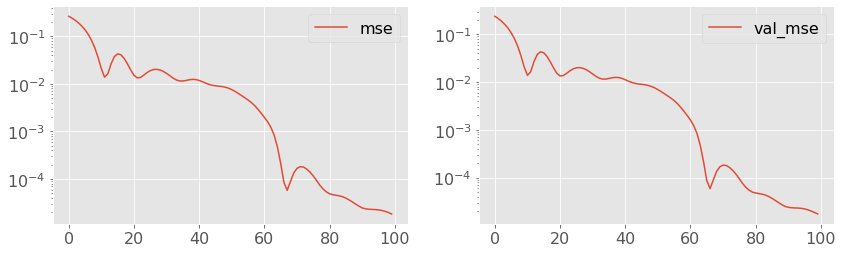

In [50]:
%%time

epochs = 100
lr = 1e-3
batch_size = y_train.shape[0]

input_shape = y_train.shape[1]
latent_dim = 4
encoder_units = [128, 16]
encoder_acts = ['relu', 'relu']

decoder_units = [16, 128, 512]
decoder_acts = ['relu', 'relu', 'relu']

# decoder_units = [16, 128]
# decoder_acts = ['relu', 'relu']

# decoder_units = [16, 128, 128, 128]
# decoder_acts = ['relu', 'relu', 'relu', 'relu']

encoder_model_2 = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
decoder_model_2 = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
ae_model_2 = build_autoencoder(
    input_shape, encoder_model_2, decoder_model_2
)

history_2, model_2 = initial_fit(
    ae_model_2,
    y=y_train,
    yval=y_val,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr
)

In [59]:
get_ann_input(modelling_params['times'], 1)

array([[-500. ,    1. ],
       [-499.5,    1. ],
       [-499. ,    1. ],
       ...,
       [  73.5,    1. ],
       [  74. ,    1. ],
       [  74.5,    1. ]])

In [71]:
def compare_models(index):
    
    
    times = modelling_params['times']
    

#     mass_ratio = modelling_params['x'][index]
#     ann_input = get_ann_input(times, mass_ratio)
    
    y = modelling_params['y'][index]
    
    ann_input = y.copy()
    ann_input = ann_input.reshape(-1,1)
    
    yhat = model.predict(ann_input)[:,0]
    yhat2 = model_2.predict(ann_input)[:,0]
    
    
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat')
    plt.plot(times, yhat2, label='yhat2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 0)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.plot(times, y-yhat2, label='y-yhat2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"{modelling_params['approximants'][index]}: q={np.around(modelling_params['x'][index], 3)}"
    plt.suptitle(title)

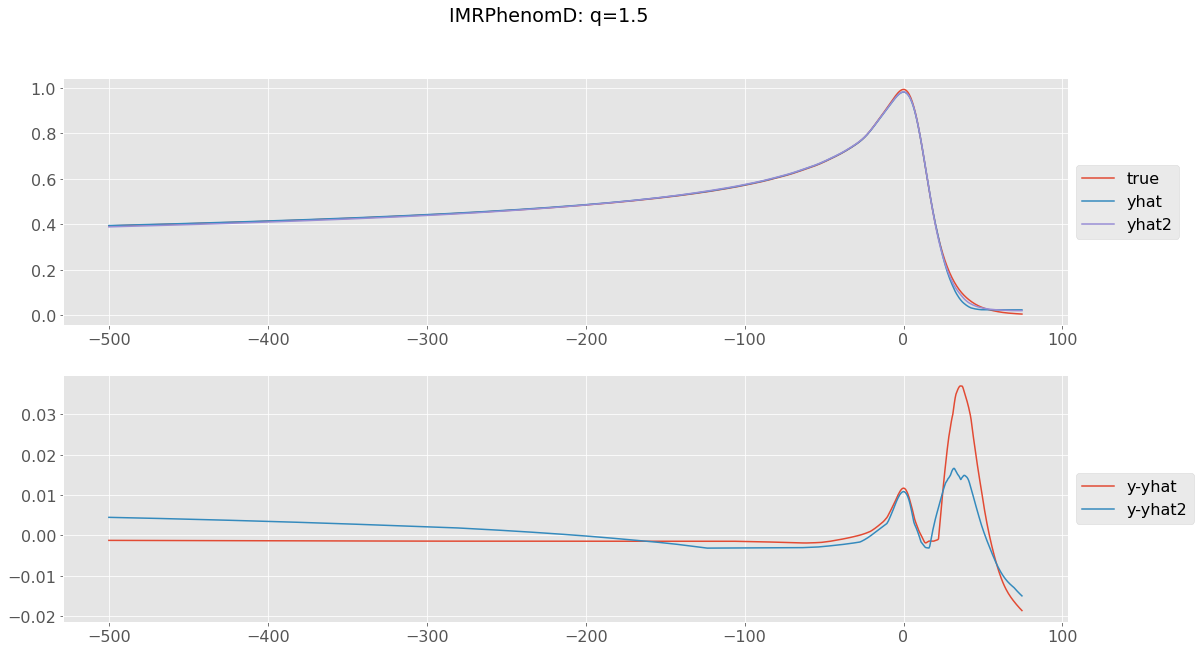

In [72]:
compare_models(5)

In [76]:
encoder_model.predict(y_train)[:,0].shape

(115000,)

In [77]:
modelling_params['x'].shape

(100,)

In [82]:
X_train.shape

(115000, 2)

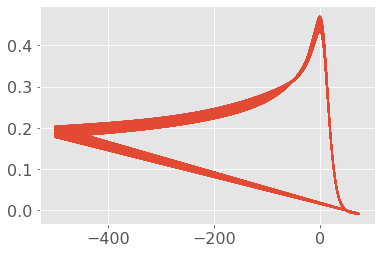

In [85]:
plt.figure()
plt.plot(X_train[:,0], encoder_model.predict(y_train)[:,0], '-')

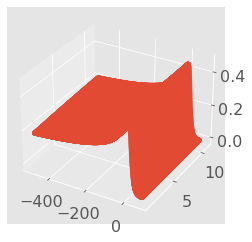

In [86]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], encoder_model.predict(y_train)[:,0])

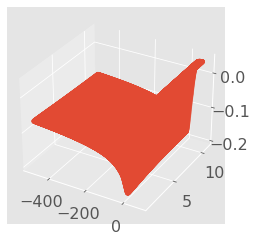

In [87]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], encoder_model.predict(y_train)[:,1])

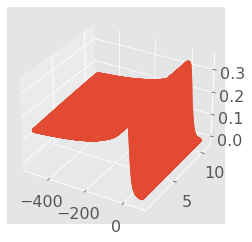

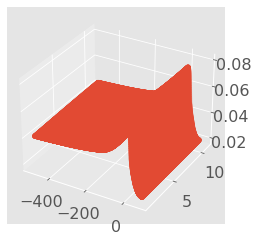

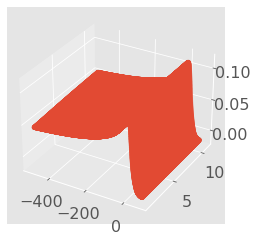

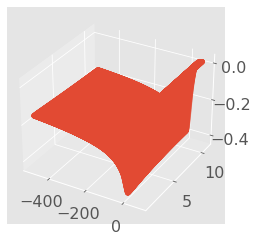

In [88]:
for i in range(4):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X_train[:,0], X_train[:,1], encoder_model_2.predict(y_train)[:,i])

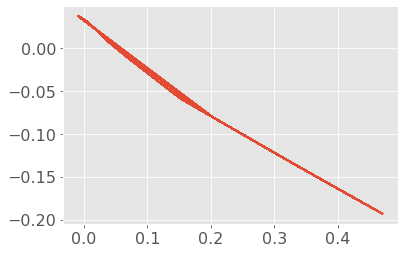

In [80]:
plt.figure()
plt.plot(encoder_model.predict(y_train)[:,0], encoder_model.predict(y_train)[:,1], '-')

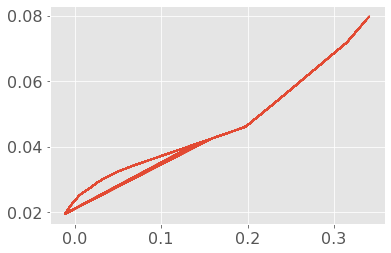

In [81]:
plt.figure()
plt.plot(encoder_model_2.predict(y_train)[:,0], encoder_model_2.predict(y_train)[:,1], '-')

# try to understand why the two-stage autoencoder with residual input for stage 2 works so well

## and then how to remove the need for the residual as input so we can actually use it!

## maybe this is a form of pre-training...